## Загрузка данных

Задача от обсерватории «Небо на ладони»: придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. Обычно для расчёта температуры учёные пользуются следующими методами:
Закон смещения Вина.
Закон Стефана-Больцмана.
Спектральный анализ.
Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.
В базе обсерватории есть характеристики уже изученных 240 звёзд.

In [1]:
!pip install phik

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import phik
import torch
import torch.nn as nn

from phik import report
from phik.report import plot_correlation_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [3]:
RANDOM_STATE = 222222

In [4]:
df = pd.read_csv("/datasets/6_class.csv", index_col=0)

In [5]:
df.head(10)

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red
5,2840,0.000650,0.1100,16.98,0,Red
6,2637,0.000730,0.1270,17.22,0,Red
7,2600,0.000400,0.0960,17.40,0,Red
8,2650,0.000690,0.1100,17.45,0,Red
9,2700,0.000180,0.1300,16.05,0,Red


In [6]:
df.describe(percentiles=[.5]).T

,count,mean,std,min,50%,max
Temperature (K),240.0,10497.462500,9552.425037,1939.00000,5776.0000,40000.00
Luminosity(L/Lo),240.0,107188.361635,179432.244940,0.00008,0.0705,849420.00
Radius(R/Ro),240.0,237.157781,517.155763,0.00840,0.7625,1948.50
Absolute magnitude(Mv),240.0,4.382396,10.532512,-11.92000,8.3130,20.06
Star type,240.0,2.500000,1.711394,0.00000,2.5000,5.00


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB


In [8]:
display(f"Количество дублированных строк: {df.duplicated().sum()}")

'Количество дублированных строк: 0'

## Предобработка и анализ данных

### Анализ первоначальных данных

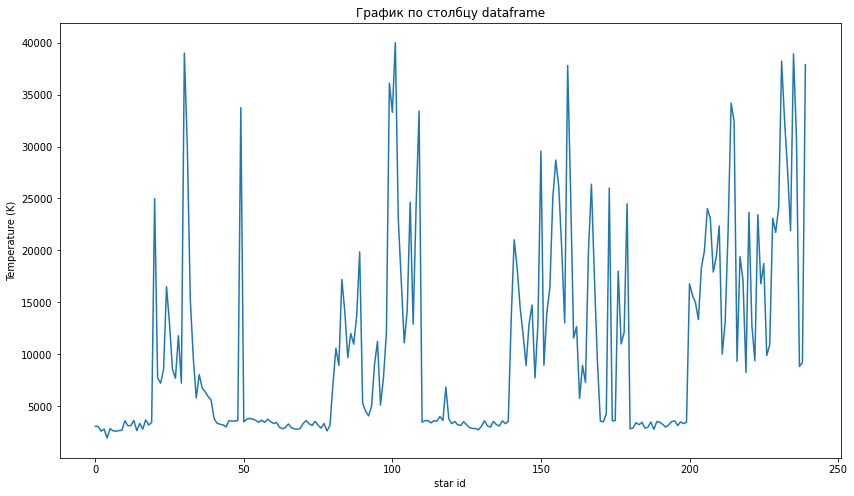

In [9]:
# Создаем график
plt.figure(figsize=(14, 8)) # Задаем размер графика

# Строим график с помощью функции plot
plt.plot(df['Temperature (K)']) # Замените 'column_name' на название вашего столбца

# Добавляем заголовок и метки осей
plt.title('График по столбцу dataframe')
plt.xlabel('star id')
plt.ylabel('Temperature (K)')

# Отображаем график
plt.show()

Звёзды делятся на разные классы и виды по температуре. Вот эти классы и виды:

Звёзды класса A — имеют небольшую температуру в 7 500–10 000 Кельвинов. Светятся белым светом.
Звёзды класса B — имеют температуру в 10 000 — 30 000 К. Светятся бело-голубым светом.
Звёзды класса F — имеют температуру в 6 000 — 7 500 К. Истинный цвет — жёлто-белый.
Звёзды класса G — имеют температуру в 5 000 — 6 000 К. Светятся жёлтым светом, как и в небе.
Звёзды класса K — имеют температуру в 3 500 — 5 000 К. Светятся оранжевым. В небе видны как жёлтовато-оранжевые.
Звёзды класса M — имеют низкую температуру в 2 000–3 500 К. Светятся красным, в небе можно увидеть их как оранжево-красные.
Звёзды класса O — имеют высокую температуру в 30 000 — 60 000 К. Светятся голубым светом, как и в небе.

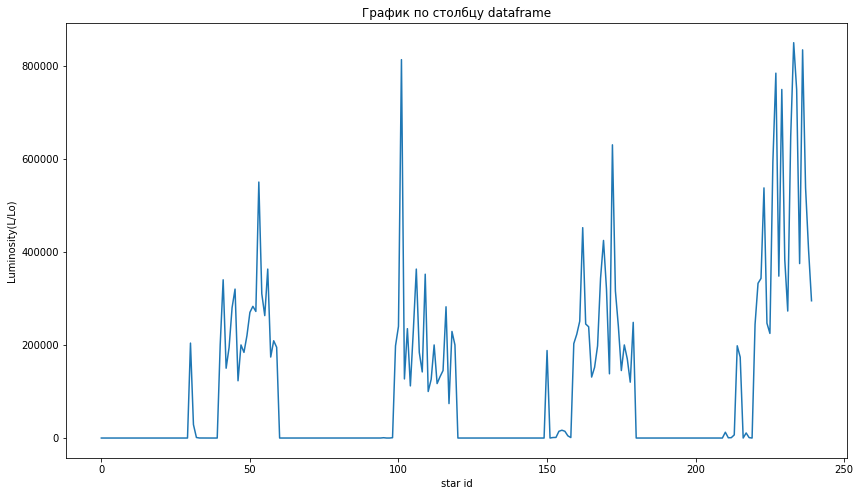

In [10]:
# Создаем график
plt.figure(figsize=(14, 8)) # Задаем размер графика

# Строим график с помощью функции plot
plt.plot(df['Luminosity(L/Lo)']) # Замените 'column_name' на название вашего столбца

# Добавляем заголовок и метки осей
plt.title('График по столбцу dataframe')
plt.xlabel('star id')
plt.ylabel('Luminosity(L/Lo)')

# Отображаем график
plt.show()

Тут делим по светимости на солнцеподобные и те, что выше солнца. Очень низкая, низкая, средняя, высокая, очень высокая

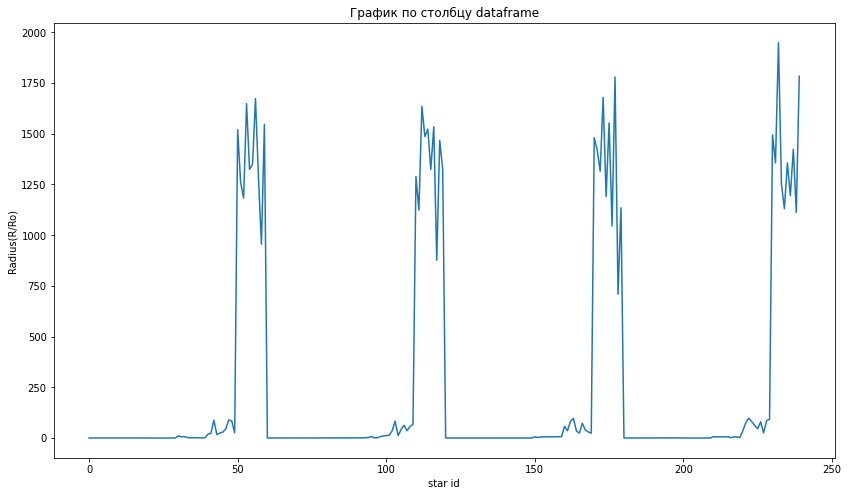

In [11]:
# Создаем график
plt.figure(figsize=(14, 8)) # Задаем размер графика

# Строим график с помощью функции plot
plt.plot(df['Radius(R/Ro)']) # Замените 'column_name' на название вашего столбца

# Добавляем заголовок и метки осей
plt.title('График по столбцу dataframe')
plt.xlabel('star id')
plt.ylabel('Radius(R/Ro)')

# Отображаем график
plt.show()

По радиусу очень маленькие, маленькие, средние, большие, очень большие 

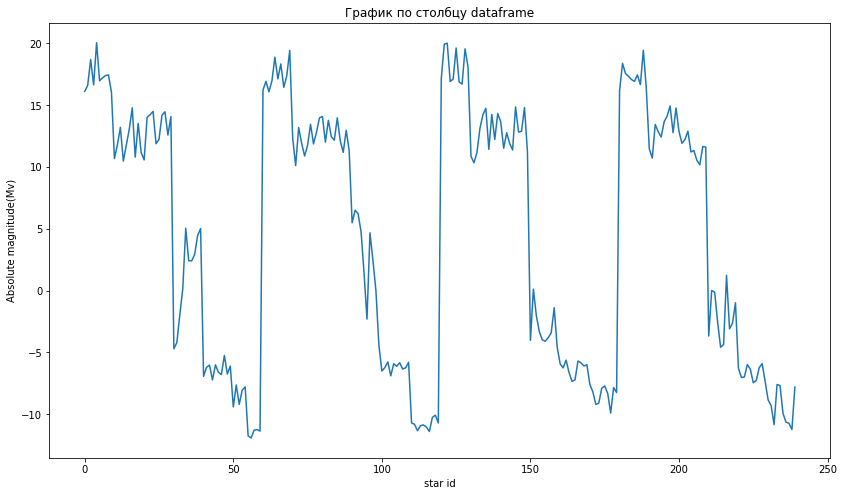

In [12]:
# Создаем график
plt.figure(figsize=(14, 8)) # Задаем размер графика

# Строим график с помощью функции plot
plt.plot(df['Absolute magnitude(Mv)']) # Замените 'column_name' на название вашего столбца

# Добавляем заголовок и метки осей
plt.title('График по столбцу dataframe')
plt.xlabel('star id')
plt.ylabel('Absolute magnitude(Mv)')

# Отображаем график
plt.show()

По магнитуде, маленькие, средние, большие, очень большие 

<AxesSubplot:>

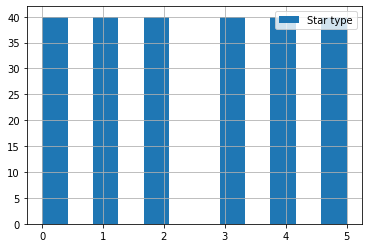

In [13]:
df['Star type'].hist(bins=12, legend=True)

In [14]:
def print_pie(grouped):
    sizes = grouped
    labels = grouped.index

    fig1, ax1 = plt.subplots(figsize=(6, 5))
    fig1.subplots_adjust(0.3,0,1.5,1)


    theme = plt.get_cmap('bwr')
    ax1.set_prop_cycle("color", [theme(1.3 * i / len(sizes)) for i in range(len(sizes))])

    ax1.pie(sizes, startangle=90)

    ax1.axis('equal')

    total = sum(sizes)
    plt.legend(
        loc='upper left',
        labels=['%s, %1.1f%%' % (
            l, (float(s) / total) * 100) for l, s in zip(labels, sizes)],
        prop={'size': 11},
        bbox_to_anchor=(0.0, 1),
        bbox_transform=fig1.transFigure
    )

    plt.show()

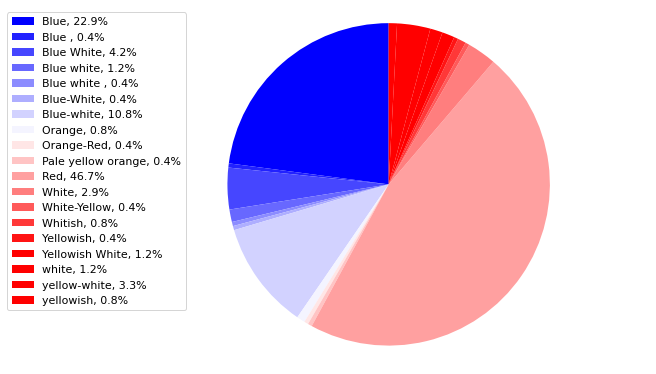

In [15]:
grouped = df.groupby('Star color').size()
print_pie(grouped)

Вывод: В категориальной переменной "Star color" много неявных дубликатов. В остальном ни выбывающихся значений, ни пропусков, ни явных дубликатов не наблюдается. Остаётся только исправиить значения колонки "Star color", построить хитмап корреляции параметров и упростить названия колонок для дальнейшей работы.

### Предобработка данных

In [16]:
# Изменим имеющиеся названия столбцов путем упрощения
df.columns = ['temp', 'luminosity', 'radius', 'magnitude', 'type', 'color']

In [17]:
def star_color(temp):
    if x > 30000:
        return 'Blue'
    elif 30000 >= temp > 10000:
        return 'Blue_white'
    elif 10000 >= temp > 7400:
        return 'White'
    elif 7400 >= temp > 6000:
        return 'Yellow_white'
    elif 6000 >= temp > 5000:
        return 'Yellow'
    elif 5000 >= temp > 3800:
        return 'Orange'
    else:
        return 'Red'

In [18]:
df['color'] = df['color'].str.lower()
df['color'] = df['color'].str.strip()
df['color'] = df['color'].str.replace('-', ' ').replace('  ', ' ')

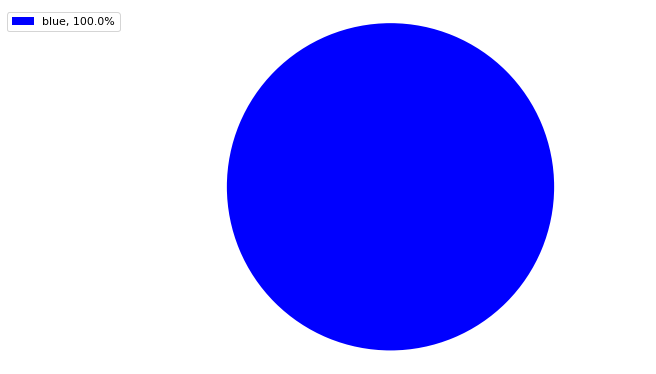

In [19]:
grouped = df.query('temp > 30000').groupby('color').size()
print_pie(grouped)

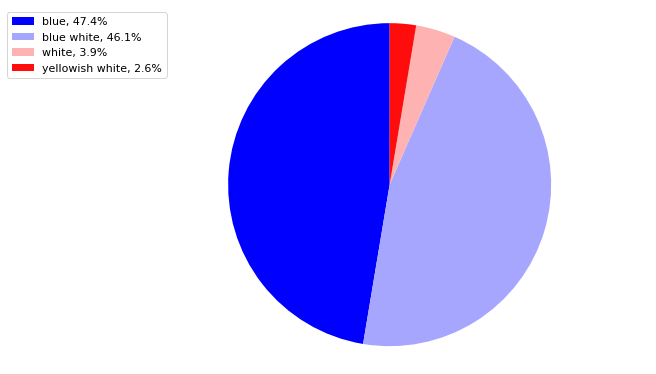

In [20]:
grouped = df.query('30000 >= temp > 10000').groupby('color').size()
print_pie(grouped)

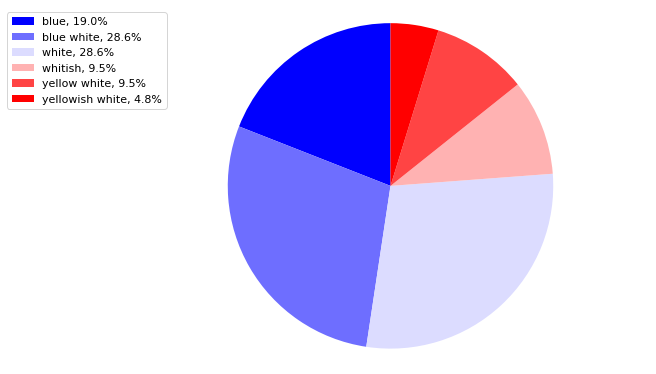

In [21]:
grouped = df.query('10000 >= temp > 7400').groupby('color').size()
print_pie(grouped)

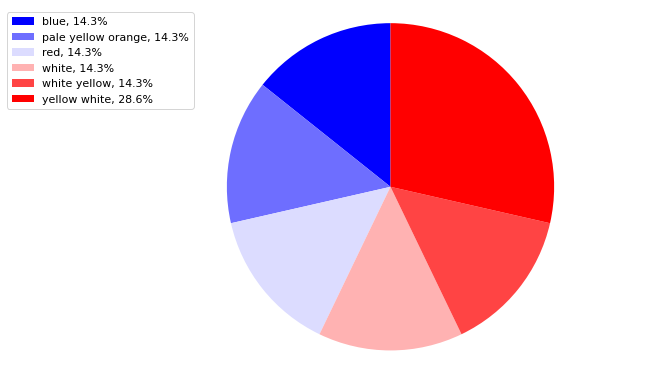

In [22]:
grouped = df.query('7400 >= temp > 6000').groupby('color').size()
print_pie(grouped)

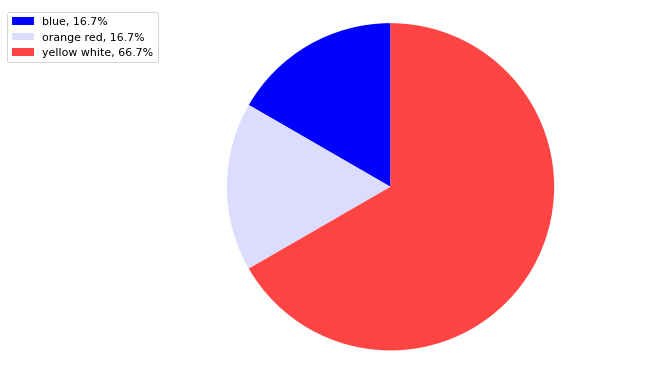

In [23]:
grouped = df.query('6000 >= temp > 5000').groupby('color').size()
print_pie(grouped)

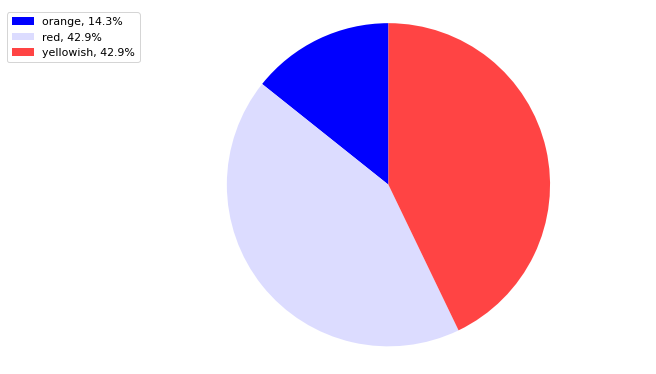

In [24]:
grouped = df.query('5000 >= temp > 3800').groupby('color').size()
print_pie(grouped)

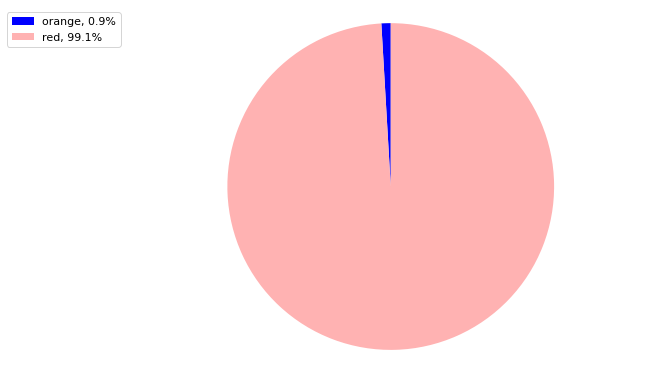

In [25]:
grouped = df.query('temp <= 3800').groupby('color').size()
print_pie(grouped)

In [26]:
df.loc[df['color'] == 'yellowish' , 'color'] = 'orange'
df.loc[df['color'] == 'pale yellow orange', 'color'] = 'white yellow'
df.loc[(df['color'] == 'whitish')| (df['color'] == 'yellowish white'), 'color'] = 'white'

In [27]:
# df.loc[
#     df['color'] == 'Blue ',
#     'color'
# ] = 'Blue'

# # Blue and white
# df.loc[
#     (df['color'] == 'Blue white') | 
#     (df['color'] == 'Blue-white') |
#     (df['color'] == 'Blue-White') |
#     (df['color'] == 'Blue white '), 
#     'color'
# ] = 'Blue White'

# # White
# df.loc[
#     (df['color'] == 'white') |
#     (df['color'] == 'Whitish') |
#     (df['color'] == 'whitish'),
#     'color'
# ] = 'White'

# # Yellow
# df.loc[
#     (df['color'] == 'Yellowish White') |
#     (df['color'] == 'yellow-white') | 
#     (df['color'] == 'White-Yellow') |
#     (df['color'] == 'Yellow White') |
#     (df['color'] == 'yellowish') |
#     (df['color'] == 'Yellowish') |
#     (df['color'] == 'Pale yellow orange'),
#     'color'
# ] = 'Yellow'

# # Orange and red
# df.loc[
#     (df['color'] == 'Orange-Red') |
#     (df['color'] == 'Orange Red'),
#     'color'
# ] = 'Orange'
# df['color'] = df['temp'].apply(star_color)

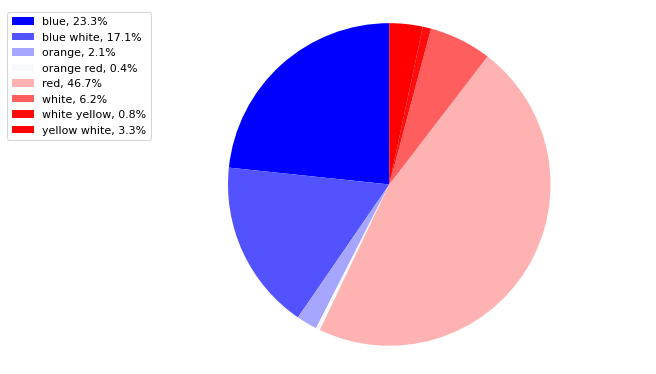

In [28]:
grouped = df.groupby('color').size()
print_pie(grouped)

interval columns not set, guessing: ['temp', 'luminosity', 'radius', 'magnitude', 'type']


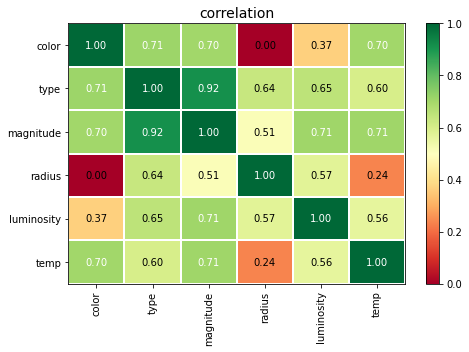

In [29]:
phik_overview = df.phik_matrix()
phik_overview.round(2)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0,
    vmax=1
)

Вывод: Была проделана комплексная работа по анализу и предобработке данных. В ходе которой были выявлены и устранены неявные дубликаты в колонке с цветом звезды, также была построена матрица корреляции. Из данной матрицы следует, что все значения мультиколлинеарны - следовательно стоит использовать методы регуляризации параметров или исключение некоторых признаков.
Целевая переменная Temperature в основном завит от цвета звезды и её магнитуды, а меньше всего опирается на размер и светимость звезды.

## Построение базовой нейронной сети

In [30]:
train = df.drop('temp', axis=1)
test = df['temp']
train

,luminosity,radius,magnitude,type,color
0,0.002400,0.1700,16.12,0,red
1,0.000500,0.1542,16.60,0,red
2,0.000300,0.1020,18.70,0,red
3,0.000200,0.1600,16.65,0,red
4,0.000138,0.1030,20.06,0,red
...,...,...,...,...,...
235,374830.000000,1356.0000,-9.93,5,blue
236,834042.000000,1194.0000,-10.63,5,blue
237,537493.000000,1423.0000,-10.73,5,white
238,404940.000000,1112.0000,-11.23,5,white


In [31]:
test

0       3068
1       3042
2       2600
3       2800
4       1939
       ...  
235    38940
236    30839
237     8829
238     9235
239    37882
Name: temp, Length: 240, dtype: int64

In [32]:
categorial_columns = ['type', 'color']
numeric_columns = ['luminosity', 'radius', 'magnitude']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(train, test, random_state=RANDOM_STATE)

In [34]:
encoder = OneHotEncoder(handle_unknown='ignore')
scaler = StandardScaler()

In [35]:
encoder.fit(X_train[categorial_columns])

OneHotEncoder(handle_unknown='ignore')

In [36]:
X_train_encoded = pd.DataFrame(
    encoder.transform(X_train[categorial_columns]).toarray(),
    columns=encoder.get_feature_names(categorial_columns),
    index=X_train.index
)
X_train_encoded = pd.concat((X_train[numeric_columns], X_train_encoded), axis=1)

In [37]:
X_test_encoded = pd.DataFrame(
    encoder.transform(X_test[categorial_columns]).toarray(),
    columns=encoder.get_feature_names(categorial_columns),
    index=X_test.index
)
X_test_encoded = pd.concat((X_test[numeric_columns], X_test_encoded), axis=1)

In [38]:
X_train_encoded.shape

(180, 17)

In [39]:
scaler.fit(X_train_encoded)

StandardScaler()

In [40]:
X_train_scaled = scaler.transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

In [41]:
n_in_neurons, n_out_neurons, num_epochs = X_train_encoded.shape[1], 1, 12001

In [42]:
X_train = torch.FloatTensor(X_train_scaled)
X_test = torch.FloatTensor(X_test_scaled)
y_train = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)

In [43]:
# loss = nn.MSELoss()
# Функция для инициализации весов
def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.kaiming_uniform_(
            layer.weight,
            mode='fan_in',
            nonlinearity='relu'
        )

def net_testing(hid1, hid2, out, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, num_epochs):
    # optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

    loss = nn.MSELoss()
    net = nn.Sequential(
        nn.Linear(n_in_neurons, n_hidden_neurons_1),
        hid1,
        nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
        hid2,
        nn.Linear(n_hidden_neurons_2, n_out_neurons), 
        out)
    # Инициализация весов нейросети
    # net.apply(init_weights)

    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    for epoch in range(num_epochs):
        optimizer.zero_grad()

        preds = net.forward(X_train).flatten()
        
        loss_value = loss(preds, y_train)
#         l1_lambda = 0.0005
#         l1_norm = sum(p.abs().sum() for p in net.parameters())
#         l2_lambda = 0.001
#         l2_norm = sum(p.pow(2.0).sum() for p in net.parameters())
#         loss_value = loss_value + l1_lambda * l1_norm + l2_lambda * l2_norm

        loss_value.backward()

        optimizer.step()
        if epoch % 200 == 0 or epoch == num_epochs - 1:
            net.eval()
    test_preds = net.forward(X_test).flatten()
    print(f'1-й слой: {hid1}, 2-й слой {hid2}, выход {out}')
    print(f'1-й слой: {n_hidden_neurons_1} нейронов, 2-й слой {n_hidden_neurons_2} нейронов')
    result = torch.sqrt(loss(test_preds, y_test)).item()
    print('RMSE =', result, '\n')
    return result, test_preds

In [ ]:
results = []
for hid1, hid2, out in (
    (nn.ReLU(), nn.ReLU(), nn.ReLU()), 
    (nn.LeakyReLU(), nn.LeakyReLU(), nn.LeakyReLU()), 
    (nn.ELU(), nn.ELU(), nn.ELU()), 
    (nn.ReLU(), nn.LeakyReLU(), nn.ELU()), 
    (nn.ELU(), nn.ReLU(), nn.LeakyReLU())
):
    for n_hidden_neurons_1 in range(6, 10):
        for n_hidden_neurons_2 in range(3, 7):
            result = net_testing(hid1, hid2, out, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, num_epochs)
            results.append((result[0], hid1, hid2, out, n_hidden_neurons_1, n_hidden_neurons_2, result[1]))

1-й слой: ReLU(), 2-й слой ReLU(), выход ReLU()
1-й слой: 6 нейронов, 2-й слой 3 нейронов
RMSE = 12185.00390625 

1-й слой: ReLU(), 2-й слой ReLU(), выход ReLU()
1-й слой: 6 нейронов, 2-й слой 4 нейронов
RMSE = 12185.00390625 

1-й слой: ReLU(), 2-й слой ReLU(), выход ReLU()
1-й слой: 6 нейронов, 2-й слой 5 нейронов
RMSE = 12185.00390625 

1-й слой: ReLU(), 2-й слой ReLU(), выход ReLU()
1-й слой: 6 нейронов, 2-й слой 6 нейронов
RMSE = 12185.00390625 

1-й слой: ReLU(), 2-й слой ReLU(), выход ReLU()
1-й слой: 7 нейронов, 2-й слой 3 нейронов
RMSE = 4991.74462890625 

1-й слой: ReLU(), 2-й слой ReLU(), выход ReLU()
1-й слой: 7 нейронов, 2-й слой 4 нейронов
RMSE = 5020.181640625 



In [ ]:
win1, win2, win3 = sorted(results, key=lambda x: x[0], reverse=False)[: 3]
display(win1[:6], win2[:6], win3[:6])

In [ ]:
# Функция для отображения графика "Факт-Прогноз"
def show_graph(y_pred):
    start = 0
    end = 30
    
    basic_df = y_test[start:end]
    nn_df = y_pred[start:end]

    plt.figure(figsize=(7, 7))
    plt.bar(range(start, end), nn_df.detach().numpy(), color='orange', label='Прогноз')
    plt.bar(range(start, end), basic_df, color='blue', width=0.5, label='Факт')

    plt.legend()
    plt.title('Факт-Прогноз', fontsize=16)
    plt.xlabel('Номер звезды в таблице данных', fontsize=14)
    plt.ylabel('Температура звезды', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

## Создание графика "Факт-Прогноз" по полученным результатам нейросети

In [ ]:
show_graph(win1[6])

Выберем модель (ELU(alpha=1.0), ReLU(), LeakyReLU(negative_slope=0.01), 9, 4) т.к. она выдаёт лучший результат на тестовой выборке и имеет меньше всего нейронов в скрытых слоях, что уменьшит вероятность переобучения.

## Улучшение нейронной сети

In [ ]:
win1, win2, win3 = sorted(results, key=lambda x: x[0], reverse=False)[: 3]
display(win1, win2, win3)

In [ ]:
def net_result(hid1, hid2, out, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, num_epochs):
    # optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

    loss = nn.MSELoss()
    net = nn.Sequential(
        nn.Linear(n_in_neurons, n_hidden_neurons_1),
        nn.BatchNorm1d(n_hidden_neurons_1),
        hid1,
        nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
        nn.BatchNorm1d(n_hidden_neurons_2),
        hid2,
        nn.Linear(n_hidden_neurons_2, n_out_neurons), 
        # nn.BatchNorm1d(n_out_neurons),
        out)
    # Инициализация весов нейросети
    # net.apply(init_weights)

    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    for epoch in range(num_epochs):
        optimizer.zero_grad()

        preds = net.forward(X_train).flatten()
        
        loss_value = loss(preds, y_train)
#         l1_lambda = 0.0005
#         l1_norm = sum(p.abs().sum() for p in net.parameters())
#         l2_lambda = 0.001
#         l2_norm = sum(p.pow(2.0).sum() for p in net.parameters())
#         loss_value = loss_value + l1_lambda * l1_norm + l2_lambda * l2_norm

        loss_value.backward()

        optimizer.step()
        if epoch % 200 == 0 or epoch == num_epochs - 1:
            net.eval()
    test_preds = net.forward(X_test).flatten()
    print(f'1-й слой: {hid1}, 2-й слой {hid2}, выход {out}')
    print(f'1-й слой: {n_hidden_neurons_1} нейронов, 2-й слой {n_hidden_neurons_2} нейронов')
    result = torch.sqrt(loss(test_preds, y_test)).item()
    print('RMSE =', result, '\n')
    return result, test_preds

In [ ]:
result = net_result(nn.LeakyReLU(), nn.LeakyReLU(), nn.LeakyReLU(), n_in_neurons, 8, 5, n_out_neurons, 12001)

## Выводы